In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import datetime

import time
from tqdm.auto import tqdm

import requests
import glob
import os
import shutil

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn import metrics 


plt.style.use('ggplot')

# Import data

In [2]:
df = pd.read_csv('Energy_production_weather.csv')

In [6]:
df['Wind_tot'] = df['Wind offshore']+df['Wind onshore']
df['Coal_tot'] = df['Fossil brown coal / lignite'] + df['Fossil hard coal']
df['Gas_tot'] = df['Fossil gas'] + df['Fossil coal-derived gas']
df['Hydro pumped storage consumption']  = -df['Hydro pumped storage consumption']
df['Hydro_tot'] = df['Hydro pumped storage consumption'] + df['Hydro Run-of-River']

types = ['Hydro pumped storage consumption', 'Hydro Run-of-River', 'Biomass', 'Geothermal', 
       'Nuclear', 'Coal_tot', 'Fossil oil', 'Gas_tot', 'Others', 'Waste',
       'Wind_tot', 'Solar']



types_rewenables = ['Wind_tot', 'Solar', 'Biomass', 'Hydro Run-of-River', 'Geothermal']
types_fossil = ['Coal_tot', 'Gas_tot', 'Fossil oil']
types_nuclear = ['Nuclear']
types_others = ['Hydro pumped storage consumption', 'Others', 'Waste']

types = types_rewenables+types_fossil+types_nuclear+types_others


keys_wind = [key for key in df.keys() if 'wind_speed' in key]
keys_radiation = [key for key in df.keys() if 'radiation_global' in key]
keys_sunshine = [key for key in df.keys() if 'sunshine_duration' in key]

# Modeling

In [8]:
df_train = df[df['year']<2023]
df_test = df[df['year']>=2023]

features = []
features.extend(keys_wind)
#features.extend(keys_radiation)
#features.extend(keys_sunshine)

features.extend(['year', 'month', 'hour'])
target = 'Wind_tot'

In [52]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

mse_list = []

model1 = LinearRegression()
model2 = Lasso()
model3 = RandomForestRegressor()
model4 = GradientBoostingRegressor()
model5 = XGBRegressor()


models = [model1, model2, model3, model4, model5]
model_names = ['Linear Regr.', 'Lasso Regr.', 'Random Forest Regr.', 'Gradient Boosting Regr.', 'XGBoost Regr.']
for model in models: 
    model.fit(df_train[features], df_train[target])

    df_test[target+'_pred'] = model.predict(df_test[features])
    df_train[target+'_pred'] = model.predict(df_train[features])
    y_true = df_test[target].values
    y_pred = df_test[target+'_pred']

    # Compute metrics
    mse_list.append(metrics.mean_squared_error(df_test[target+'_pred'].values, df_test[target].values)/(np.mean(df_test[target])**2))


/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_63461/412945950.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target+'_pred'] = model.predict(df_test[features])
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_63461/412945950.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target+'_pred'] = model.predict(df_train[features])
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_63461/412945950.py:21: SettingWithCopyWarning: 
A value is trying to be set o

<IPython.core.display.Javascript object>


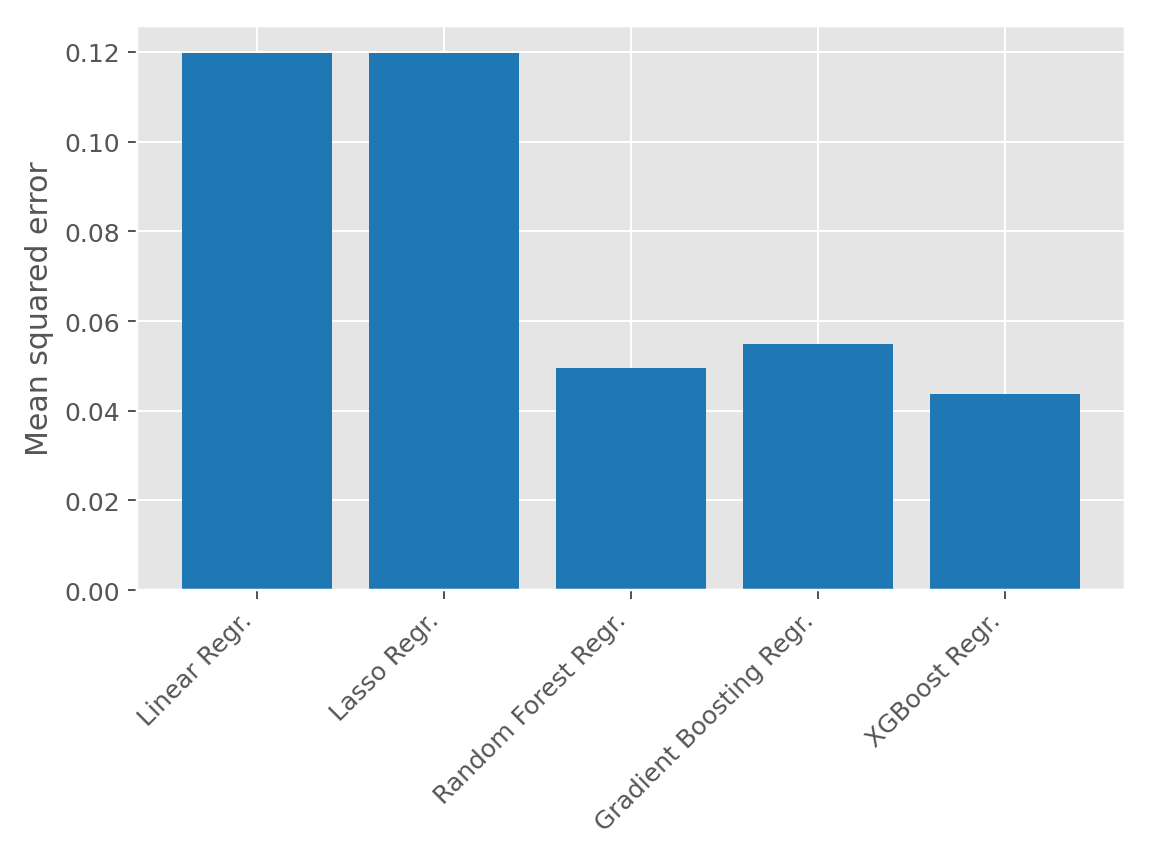

In [53]:
plt.figure()
plt.bar(model_names, mse_list, color='tab:blue')
plt.ylabel('Mean squared error')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [54]:
model = XGBRegressor()

model.fit(df_train[features], df_train[target])

df_test[target+'_pred'] = model.predict(df_test[features])
df_train[target+'_pred'] = model.predict(df_train[features])


/Users/christianliedl/anaconda3/envs/mlbasic/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/christianliedl/anaconda3/envs/mlbasic/lib/python3.10/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/christianliedl/anaconda3/envs/mlbasic/lib/python3.10/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/christianliedl/anaconda3/envs/mlbasic/lib/python3.10/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use i

## Evaluate hourly prediction

<IPython.core.display.Javascript object>


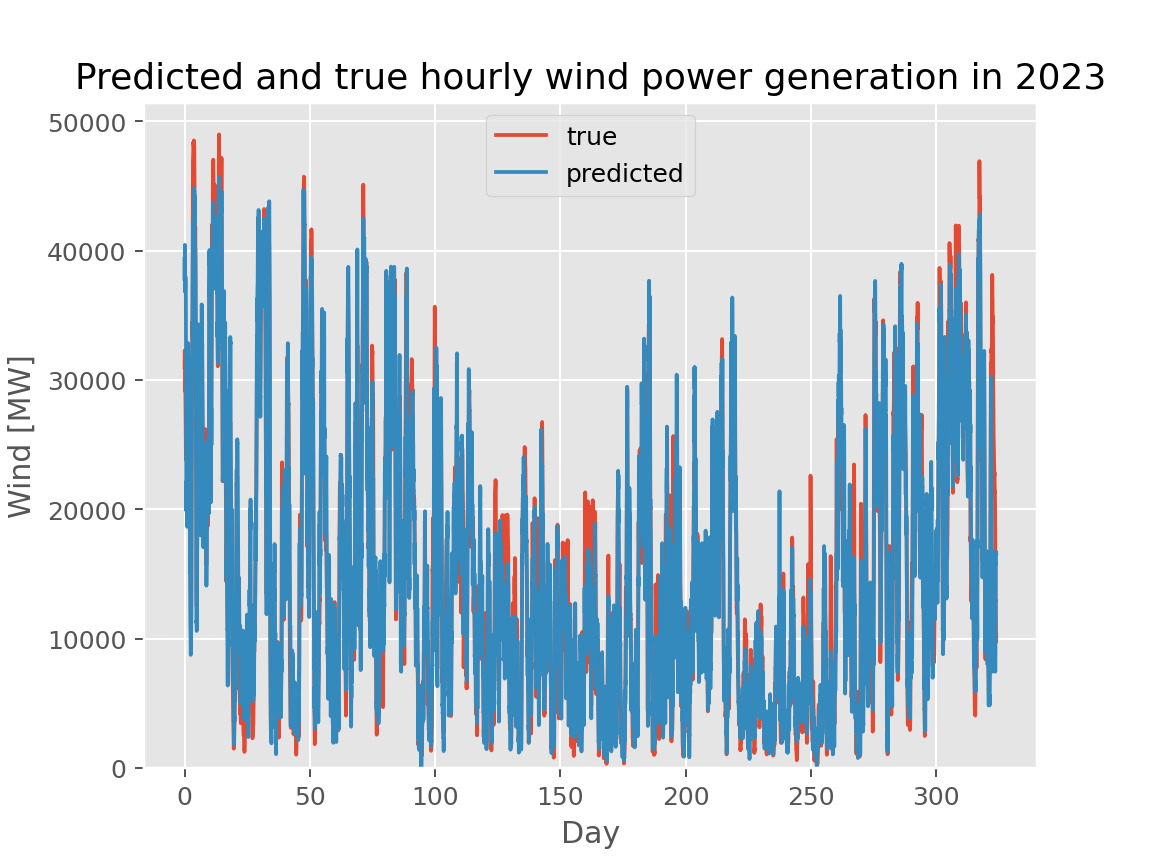

Test data: 
Mean squared error (norm.) = 0.0438
Mean absolute error (norm.) = 0.1514
R squared value = 0.91

Training data:
Mean squared error (norm.) = 0.0201
Mean absolute error (norm.) = 0.1049
R squared value = 0.9651


In [63]:
y_true = df_test[target].values
y_pred = df_test[target+'_pred']
x = np.arange(len(y_true))/24

plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')

plt.title('Predicted and true hourly wind power generation in 2023')
plt.legend()
plt.xlabel('Day')
plt.ylabel(target.split('_')[0]+' [MW]')
plt.ylim([0, None])


# Compute metrics
mse = metrics.mean_squared_error(df_test[target+'_pred'].values, df_test[target].values)/(np.mean(df_test[target])**2)
mae = metrics.mean_absolute_error(df_test[target+'_pred'].values, df_test[target].values)/(np.mean(df_test[target]))
r2 = metrics.r2_score(df_test[target+'_pred'].values, df_test[target].values)

print('Test data: ')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))
print()

# Compute metrics, training data
mse = metrics.mean_squared_error(df_train[target+'_pred'].values, df_train[target].values)/(np.mean(df_train[target])**2)
mae = metrics.mean_absolute_error(df_train[target+'_pred'].values, df_train[target].values)/(np.mean(df_train[target]))
r2 = metrics.r2_score(df_train[target+'_pred'].values, df_train[target].values)
print('Training data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

plt.savefig('hourly_predictions_wind_XGBoost.png')



<IPython.core.display.Javascript object>


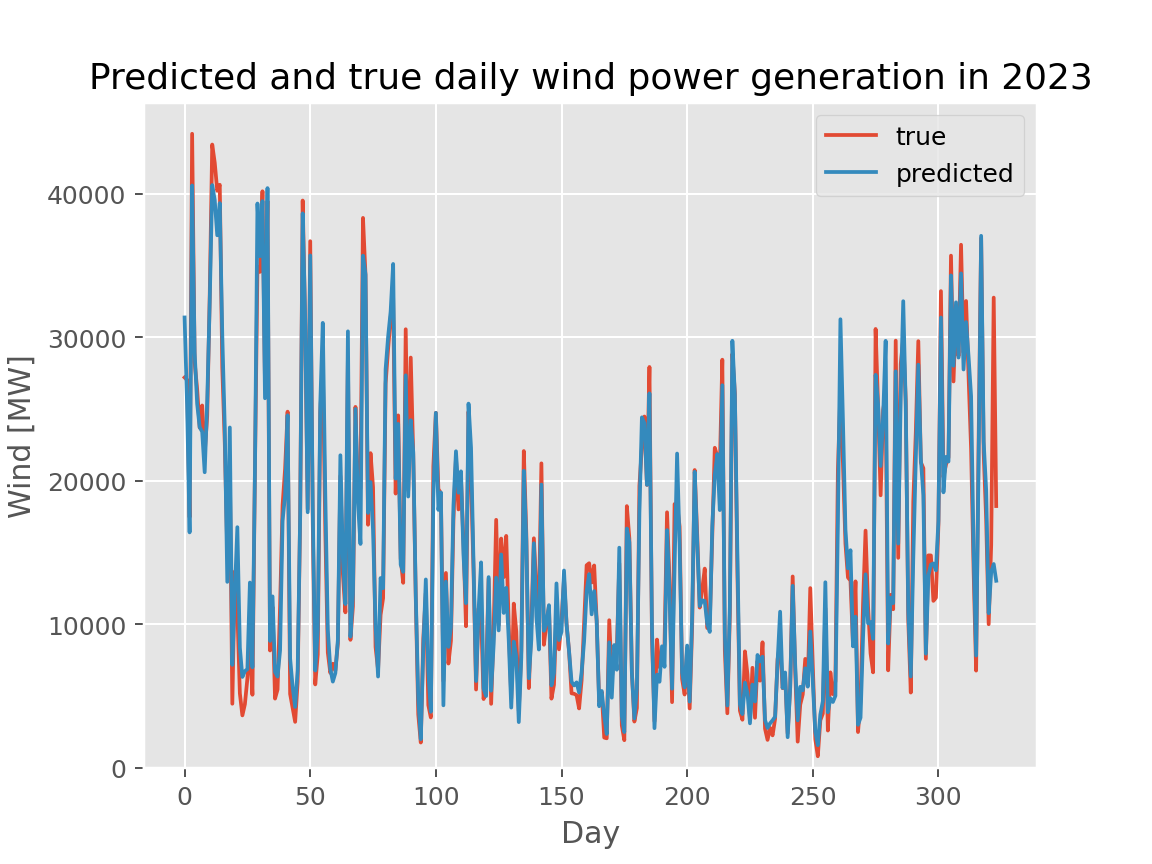

Test data:
Mean squared error (norm.) = 0.0171
Mean absolute error (norm.) = 0.0889
R squared value = 0.958
Training data:
Mean squared error (norm.) = 0.0008
Mean absolute error (norm.) = 0.0221
R squared value = 0.9947


In [64]:
df_t = df_test.groupby('date')[[target, target+'_pred']].mean()
df_tr = df_train.groupby('date')[[target, target+'_pred']].mean()

y_true = df_t[target].values
y_pred = df_t[target+'_pred']
x = np.arange(len(y_true))

plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')

plt.title('Predicted and true daily wind power generation in 2023')
plt.legend()
plt.xlabel('Day')
plt.ylabel(target.split('_')[0]+' [MW]')
plt.ylim([0, None])


# Compute metrics
mse = metrics.mean_squared_error(df_t[target+'_pred'].values, df_t[target].values)/(np.mean(df_t[target])**2)
mae = metrics.mean_absolute_error(df_t[target+'_pred'].values, df_t[target].values)/(np.mean(df_t[target]))
r2 = metrics.r2_score(df_t[target+'_pred'].values, df_t[target].values)

print('Test data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

# Compute metrics, training data
mse = metrics.mean_squared_error(df_tr[target+'_pred'].values, df_tr[target].values)/(np.mean(df_tr[target])**2)
mae = metrics.mean_absolute_error(df_tr[target+'_pred'].values, df_tr[target].values)/(np.mean(df_tr[target]))
r2 = metrics.r2_score(df_tr[target+'_pred'].values, df_tr[target].values)
print('Training data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

plt.savefig('daily_predictions_wind_XGBoost.png')
